# Обучение базовой модели ~~логистической регрессии~~ градиентного бустинга

In [1]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir('/content/drive/Shared drives/Кредитные риски')
!pip install -r CreditRisks/PythonBackend/requirements.txt

In [3]:
!nvidia-smi

Fri Apr  3 19:40:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
sys.path.append(os.path.abspath(os.path.join('.', 'CreditRisks/metrics_library')))
sys.path.append(os.path.abspath(os.path.join('.', 'CreditRisks/PythonBackend')))

In [0]:
import pandas as pd
import numpy as np
import os
import io
import pickle
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import category_encoders
import matplotlib.pyplot as plt

In [0]:
from calc_model.cb_model import CatBoostModel
from feature_generation import add_features
import profits

In [0]:
DIR_IN = 'Датасеты/revision_006/'
DIR_OUT = 'Датасеты/revision_006/cb_model/'
!mkdir -p {DIR_OUT}

## Считывание данных

In [0]:
df_train = pd.read_pickle(f'{DIR_IN}companies_ready_train.pkl')
y_train = df_train['target']
x_train = df_train.drop(columns=['target'])

df_test = pd.read_pickle(f'{DIR_IN}companies_ready_test.pkl')
y_test = df_test['target']
x_test = df_test.drop(columns=['target'])

df_prod = pd.read_pickle(f'{DIR_IN}companies_ready_prod.pkl')
y_prod = df_prod['target']
x_prod = df_prod.drop(columns=['target'])

## Предобработка данных

### Добавление новых признаков

In [0]:
add_features(x_train)
add_features(x_test)
add_features(x_prod)

In [0]:
features_all = ['region', 'year_-1_1100', 'year_-1_1150', 'year_-1_1200',
       'year_-1_1210', 'year_-1_1300', 'year_-1_1310', 'year_-1_1500',
       'year_-1_1520', 'year_-1_2110', 'year_-1_2120',
       'year_-1_AssetTurnover',
       'year_-1_CoverageDebtWithAccumulatedProfit',
       'year_-1_CreditLeverage', 'year_-1_CurrentLiquidity',
       'year_-1_DebtBurden', 'year_-1_LevelOfOperatingAssets',
       'year_-1_LiabilityCoverageOperatingProfit',
       'year_-1_NetProfitMargin',
       'year_-1_OperatingProfitFinancialDebtRatio',
       'year_-1_QuickLiquidity', 'year_-1_ReturnAssetsNetProfit',
       'year_-1_okved', 'year_-1_okved1', 'year_-1_okved2',
       'year_-2_1150', 'year_-2_1200', 'year_-2_1230', 'year_-2_1310',
       'year_-2_1500', 'year_-2_1520', 'year_-2_1600', 'year_-2_2100',
       'year_-2_2110', 'year_-2_2120', 'year_-2_2300', 'year_-2_2400',
       'year_0_1100', 'year_0_1150', 'year_0_1200', 'year_0_1210',
       'year_0_1230', 'year_0_1250', 'year_0_1300', 'year_0_1310',
       'year_0_1500', 'year_0_1520', 'year_0_2300', 'year_0_2400',
       'year_0_AssetTurnover', 'year_0_CoverageDebtWithAccumulatedProfit',
       'year_0_CreditLeverage', 'year_0_DebtBurden',
       'year_0_FinancialCycle', 'year_0_InstantLiquidity',
       'year_0_LevelOfOperatingAssets',
       'year_0_LiabilityCoverageOperatingProfit',
       'year_0_NetProfitMargin',
       'year_0_OperatingProfitFinancialDebtRatio',
       'year_0_ReturnAssetsNetProfit', 'year_0_financialDebt',
       'year_0_okved', 'year_0_okved1', 'year_0_okved2',
       'year_0_turnoverCreditDebt', 'year_0_turnoverDebtorDebt',
       'year_0_turnoverReserves']
features_all = np.array(features_all)

In [0]:
with open(f'{DIR_OUT}cols.pkl', 'wb') as f:
    pickle.dump(features_all, f)

In [0]:
x_train = x_train[features_all]
x_test = x_test[features_all]
x_prod = x_prod[features_all]

# CatBoost

In [13]:
x_train

,region,year_-1_1100,year_-1_1150,year_-1_1200,year_-1_1210,year_-1_1300,year_-1_1310,year_-1_1500,year_-1_1520,year_-1_2110,year_-1_2120,year_-1_AssetTurnover,year_-1_CoverageDebtWithAccumulatedProfit,year_-1_CreditLeverage,year_-1_CurrentLiquidity,year_-1_DebtBurden,year_-1_LevelOfOperatingAssets,year_-1_LiabilityCoverageOperatingProfit,year_-1_NetProfitMargin,year_-1_OperatingProfitFinancialDebtRatio,year_-1_QuickLiquidity,year_-1_ReturnAssetsNetProfit,year_-1_okved,year_-1_okved1,year_-1_okved2,year_-2_1150,year_-2_1200,year_-2_1230,year_-2_1310,year_-2_1500,year_-2_1520,year_-2_1600,year_-2_2100,year_-2_2110,year_-2_2120,year_-2_2300,year_-2_2400,year_0_1100,year_0_1150,year_0_1200,year_0_1210,year_0_1230,year_0_1250,year_0_1300,year_0_1310,year_0_1500,year_0_1520,year_0_2300,year_0_2400,year_0_AssetTurnover,year_0_CoverageDebtWithAccumulatedProfit,year_0_CreditLeverage,year_0_DebtBurden,year_0_FinancialCycle,year_0_InstantLiquidity,year_0_LevelOfOperatingAssets,year_0_LiabilityCoverageOperatingProfit,year_0_NetProfitMargin,year_0_OperatingProfitFinancialDebtRatio,year_0_ReturnAssetsNetProfit,year_0_financialDebt,year_0_okved,year_0_okved1,year_0_okved2,year_0_turnoverCreditDebt,year_0_turnoverDebtorDebt,year_0_turnoverReserves
0,1,10.0,10.0,820.0,820.0,155.0,10.0,675.0,0.0,5450.0,4360.0,6.566265,0.229630,0.229630,1.214815,0.813253,0.150459,0.266667,0.026606,0.266667,0.000000,0.174699,52.31,52,52.31,10.0,780.0,0.0,10.0,642.0,0.0,790.0,1040.0,5200.0,4160.0,170.0,138.0,10.0,10.0,850.0,850.0,0.0,0.0,164.0,10.0,696.0,0.0,189.0,154.0,6.534883,0.235632,0.235632,0.809302,54.230427,0.000000,0.151246,0.271552,0.027402,0.271552,0.179070,696.0,47.73,47,47.73,0.000000,0.000000,54.230427
1,1,337.0,337.0,10591.0,2883.0,9347.0,10.0,1.0,1.0,22903.0,20634.0,2.095809,5.001070,9347.000000,10591.000000,0.171029,0.449723,1.435168,0.096581,1.214018,7708.000000,0.202416,52.31,52,52.31,543.0,9108.0,7418.0,10.0,1.0,1.0,9651.0,4137.0,19608.0,15471.0,616.0,574.0,337.0,337.0,9512.0,2040.0,7100.0,370.0,9348.0,10.0,1.0,1.0,73.0,1.0,2.908925,10.732491,9348.000000,0.088435,123.826096,370.000000,0.318988,0.588822,0.000035,0.338691,0.000102,871.0,74.20,74,74.20,0.012740,92.479408,31.359425
2,1,2993.0,2987.0,3117.0,403.0,-42883.0,9660.0,764.0,764.0,23001.0,8079.0,3.764484,-0.872475,-56.129581,4.079843,8.044353,0.095431,0.304574,-0.198735,0.303595,3.552356,-1.598691,01.21,01,01.21,5185.0,24836.0,7198.0,9660.0,31839.0,31839.0,30027.0,-7281.0,14543.0,21824.0,-6818.0,-6818.0,2502.0,2496.0,3680.0,0.0,3649.0,31.0,-50243.0,9660.0,56425.0,10889.0,-7360.0,-7360.0,0.147687,-0.889950,-0.890439,9.132319,-1008.447510,0.000549,-7.929902,0.001825,-0.130367,0.001824,-1.190553,56456.0,01.41,01,01.41,2329.323730,1240.320312,80.555862
3,1,201.0,201.0,683.0,106.0,828.0,10.0,56.0,56.0,2278.0,2133.0,2.576923,14.033898,14.785714,12.196428,0.066742,0.273924,1.232143,0.026778,1.169492,10.303572,0.069005,52.12,52,52.12,185.0,0.0,466.0,0.0,0.0,18.0,784.0,0.0,3342.0,3274.0,0.0,62.0,166.0,166.0,741.0,0.0,740.0,1.0,888.0,10.0,19.0,19.0,69.0,61.0,2.361632,44.400002,46.736843,0.022051,114.595009,0.052632,0.336601,3.631579,0.028478,3.450000,0.067255,20.0,52.11,52,52.11,6.390056,111.953781,9.031280
4,1,190599.0,186591.0,211208.0,57020.0,269860.0,15.0,90232.0,66414.0,1570459.0,1153360.0,3.908491,1.807599,2.990735,2.340722,0.371552,0.081150,1.676537,0.043419,1.481754,1.708795,0.169703,15.51.4,15,15.51,210788.0,219298.0,137362.0,15.0,156467.0,82694.0,442185.0,375379.0,1568891.0,1193512.0,108981.0,85828.0,170483.0,166000.0,271206.0,70680.0,177028.0,23492.0,315537.0,15.0,86880.0,62933.0,118081.0,90677.0,4.007845,2.108584,3.631871,0.338799,32.187847,0.270396,0.104380,1.815952,0.051224,1.530873,0.205296,149644.0,10.51.2,10,10.51,13.334961,32.357643,13.165164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [14]:
cat_features = ['region']
for year in ['0', '-1']:
    for code in ['okved', 'okved1', 'okved2']:
        cat_features.append(f'year_{year}_{code}')
cat_features

['region',
 'year_0_okved',
 'year_0_okved1',
 'year_0_okved2',
 'year_-1_okved',
 'year_-1_okved1',
 'year_-1_okved2']

In [0]:
clf_params = {
    # 'learning_rate': 0.03948599845170975,
    # 'learning_rate': 0.031588798761367796,
    'learning_rate': 0.07688199728727341,
    # 'learning_rate': 0.1,
    # 'learning_rate': 0.01,
    'depth': 6,
    'num_trees': 348,
    'random_strength': 3,
    'bagging_temperature': 1.02,
    'cat_features': cat_features,

    'eval_metric': 'AUC',
    'random_seed': 42,
    # 'logging_level': 'Silent',
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 200,
    # 'task_type': 'GPU',
    'task_type': 'CPU',
}

In [0]:
CB_DIR_OUT = DIR_OUT + 'cbinfo_'

## Обучение

In [0]:
def plt_to_bytes():
    b = io.BytesIO()
    plt.savefig(b, format="png")
    b.seek(0)
    return b.read()

In [0]:
def measure_quality(y_true: np.array, y_predict: np.array, name=None):
    print("ROC AUC: ", roc_auc_score(y_true, y_predict))
    plts = {}
    profits.plt_profit(y_true,  y_predict, percent_space=[0.10, 0.15, 0.20, 0.25, 0.35], title=name)
    plts['plt_profit'] = plt_to_bytes()
    profits.plt_profit_recall(y_true,  y_predict, percent_space=[0.10, 0.15, 0.20, 0.25, 0.35], title=name)
    plts['plt_profit_recall'] = plt_to_bytes()
    profits.plt_popularity(y_predict, title=name) 
    plts['plt_popularity'] = plt_to_bytes()
    return plts

In [21]:
clf = CatBoostClassifier(train_dir=CB_DIR_OUT + 'final_train_cpu', **clf_params).fit(x_train, y_train, eval_set=(x_test, y_test), )
predict = clf.predict_proba(x_test)[:,1]

0:	test: 0.6221319	best: 0.6221319 (0)	total: 1.38s	remaining: 7m 58s
1:	test: 0.6463106	best: 0.6463106 (1)	total: 2.45s	remaining: 7m 4s
2:	test: 0.6538066	best: 0.6538066 (2)	total: 3.73s	remaining: 7m 9s
3:	test: 0.6574099	best: 0.6574099 (3)	total: 5s	remaining: 7m 9s
4:	test: 0.6610887	best: 0.6610887 (4)	total: 6.38s	remaining: 7m 17s
5:	test: 0.6629621	best: 0.6629621 (5)	total: 7.55s	remaining: 7m 10s
6:	test: 0.6649203	best: 0.6649203 (6)	total: 8.77s	remaining: 7m 7s
7:	test: 0.6652792	best: 0.6652792 (7)	total: 9.94s	remaining: 7m 2s
8:	test: 0.6652977	best: 0.6652977 (8)	total: 11.4s	remaining: 7m 9s
9:	test: 0.6655558	best: 0.6655558 (9)	total: 12.6s	remaining: 7m 7s
10:	test: 0.6653335	best: 0.6655558 (9)	total: 13.6s	remaining: 6m 57s
11:	test: 0.6661825	best: 0.6661825 (11)	total: 14.8s	remaining: 6m 55s
12:	test: 0.6672742	best: 0.6672742 (12)	total: 16.1s	remaining: 6m 55s
13:	test: 0.6686245	best: 0.6686245 (13)	total: 17.6s	remaining: 7m 1s
14:	test: 0.6700100	best

ROC AUC:  0.6969531072748144


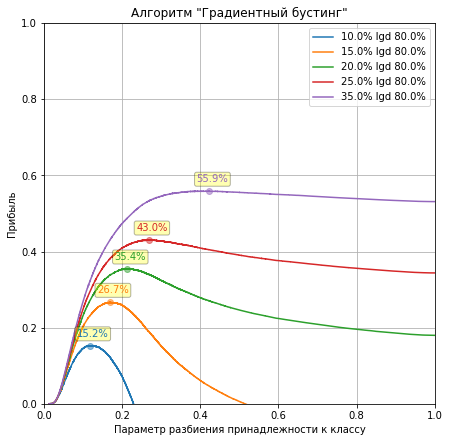

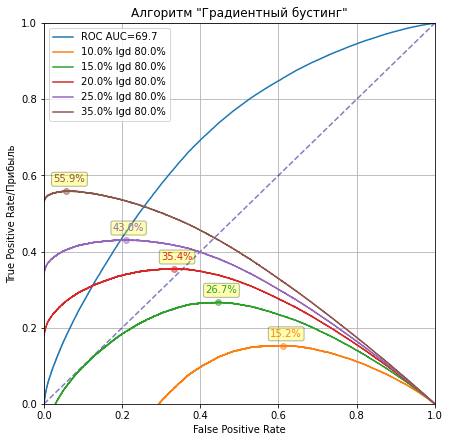

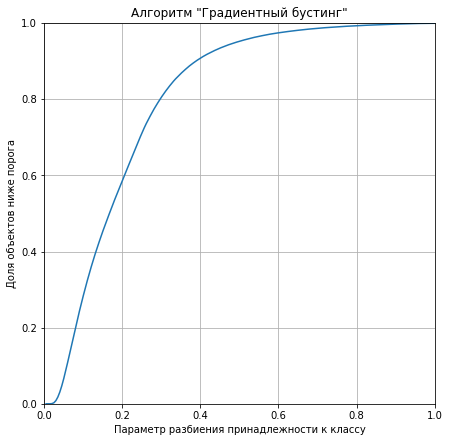

In [22]:
plts = measure_quality(y_test, predict, name='Алгоритм "Градиентный бустинг"')

In [0]:
super_clf = CatBoostModel('Градиентный бустинг', plts, features_all, np.array(cat_features), clf)
with open(f'{DIR_OUT}model_train_cpu.pkl','wb') as f:
    pickle.dump(super_clf, f)

# Модель на Production

In [24]:
clf_params_prod = clf_params.copy()
clf_params_prod['num_trees'] = clf.tree_count_
clf_params_prod['use_best_model'] = False

clf_prod = CatBoostClassifier(train_dir=CB_DIR_OUT + 'final_prod_cpu', **clf_params_prod).fit(x_prod, y_prod,)

0:	total: 1.14s	remaining: 6m 36s
1:	total: 2.32s	remaining: 6m 41s
2:	total: 3.31s	remaining: 6m 20s
3:	total: 4.26s	remaining: 6m 6s
4:	total: 5.27s	remaining: 6m 1s
5:	total: 6.17s	remaining: 5m 51s
6:	total: 7.33s	remaining: 5m 57s
7:	total: 8.51s	remaining: 6m 1s
8:	total: 9.73s	remaining: 6m 6s
9:	total: 10.7s	remaining: 6m 3s
10:	total: 11.9s	remaining: 6m 5s
11:	total: 13.1s	remaining: 6m 6s
12:	total: 14.4s	remaining: 6m 10s
13:	total: 15.4s	remaining: 6m 7s
14:	total: 16.8s	remaining: 6m 11s
15:	total: 17.7s	remaining: 6m 6s
16:	total: 18.7s	remaining: 6m 4s
17:	total: 19.8s	remaining: 6m 2s
18:	total: 21s	remaining: 6m 4s
19:	total: 22.2s	remaining: 6m 4s
20:	total: 23.5s	remaining: 6m 5s
21:	total: 24.6s	remaining: 6m 3s
22:	total: 25.8s	remaining: 6m 4s
23:	total: 27s	remaining: 6m 4s
24:	total: 28.3s	remaining: 6m 5s
25:	total: 29.5s	remaining: 6m 5s
26:	total: 30.7s	remaining: 6m 5s
27:	total: 32s	remaining: 6m 5s
28:	total: 33.2s	remaining: 6m 5s
29:	total: 34.5s	remain

In [0]:
super_clf_prod = CatBoostModel('Градиентный бустинг', plts, features_all, np.array(cat_features), clf_prod)
with open(f'{DIR_OUT}model_prod_cpu.pkl','wb') as f:
    pickle.dump(super_clf_prod, f)

In [0]:
# clf.save_model(f'{DIR_OUT}model_train_cpu.cbm')
# clf.save_model(f'{DIR_OUT}model_train.py', format='python')
# clf_prod.save_model(f'{DIR_OUT}model_prod_cpu.cbm')
# clf_prod.save_model(f'{DIR_OUT}model_prod.py', format='python')

In [27]:
!ls -lh {DIR_OUT}

total 1.9G
drwx------ 2 root root 4.0K Apr  3 11:11 cbinfo_000
drwx------ 2 root root 4.0K Apr  3 11:30 cbinfo_001
drwx------ 2 root root 4.0K Apr  3 11:33 cbinfo_002
drwx------ 2 root root 4.0K Apr  3 11:35 cbinfo_003
drwx------ 2 root root 4.0K Apr  3 11:37 cbinfo_004
drwx------ 2 root root 4.0K Apr  3 11:39 cbinfo_005
drwx------ 2 root root 4.0K Apr  3 12:02 cbinfo_final_prod
drwx------ 4 root root 4.0K Apr  3 19:58 cbinfo_final_prod_cpu
drwx------ 2 root root 4.0K Apr  3 11:47 cbinfo_final_train
drwx------ 5 root root 4.0K Apr  3 19:50 cbinfo_final_train_cpu
-rw------- 1 root root  11K Apr  3 19:41 cols.pkl
-rw------- 1 root root 472M Apr  3 12:07 model_prod.cbm
-rw------- 1 root root  33M Apr  3 12:21 model_prod_cpu.cbm
-rw------- 1 root root  33M Apr  3 19:58 model_prod_cpu.pkl
-rw------- 1 root root 472M Apr  3 12:04 model_prod.pkl
-rw------- 1 root root 392M Apr  3 12:08 model_train.cbm
-rw------- 1 root root  38M Apr  3 12:37 model_train_cpu.cbm
-rw------- 1 root root  44M Apr